# Aprendizaje automático para textos

## Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

**Comentarios del envío** Todo el proyecto se corrió de manera local, por lo que ciertas funciones pueden no ser compatibles con la vista en el Notebook de TripleTen. El límite de tamaño del envío hace que no se pueda enviar adjunto al proyecto el archivo de los resultados de utilizar Bert en los datos.

In [1]:
import math
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy
from lightgbm import LGBMClassifier

import torch
import transformers

c:\Users\Oliver\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
try:
    # Ruta en la plataforma
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except FileNotFoundError:
    df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv?etag=bbd4a8dc10e6cf1280c42d7350105c41',
                             sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
print(df_reviews.sample(5))

          tconst title_type                primary_title  \
749    tt0099327      movie            A Cry in the Wild   
37996  tt0084096      movie  The House Where Evil Dwells   
26980  tt0102719      movie              Problem Child 2   
15368  tt0031398      movie                    Gunga Din   
25866  tt0213985      movie                    Partition   

                    original_title  start_year end_year runtime_minutes  \
749              A Cry in the Wild        1990       \N              82   
37996  The House Where Evil Dwells        1982       \N              88   
26980              Problem Child 2        1991       \N              91   
15368                    Gunga Din        1939       \N             117   
25866                    Partition        2007       \N             116   

       is_adult                     genres  average_rating  votes  \
749           0  Action,Adventure,Thriller             5.5    900   
37996         0                     Horror        

In [7]:
df_reviews.duplicated().sum()

0

In [8]:
df_reviews[df_reviews.isna().any(axis=1)]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Observamos que los valores faltantes son en la misma película, pero no en la columna de review, entonces podemos ignorarlas.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

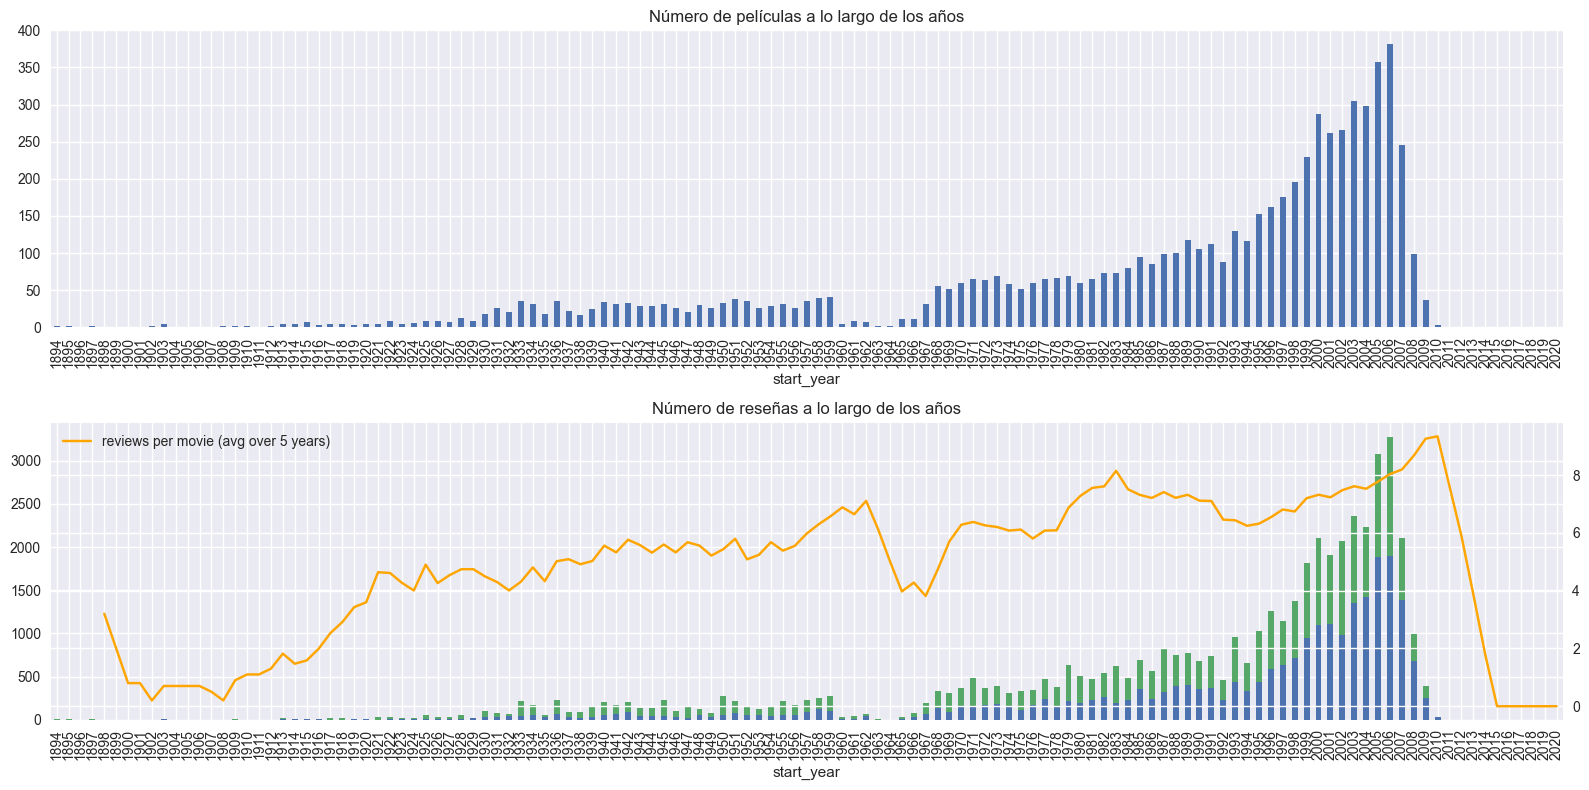

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

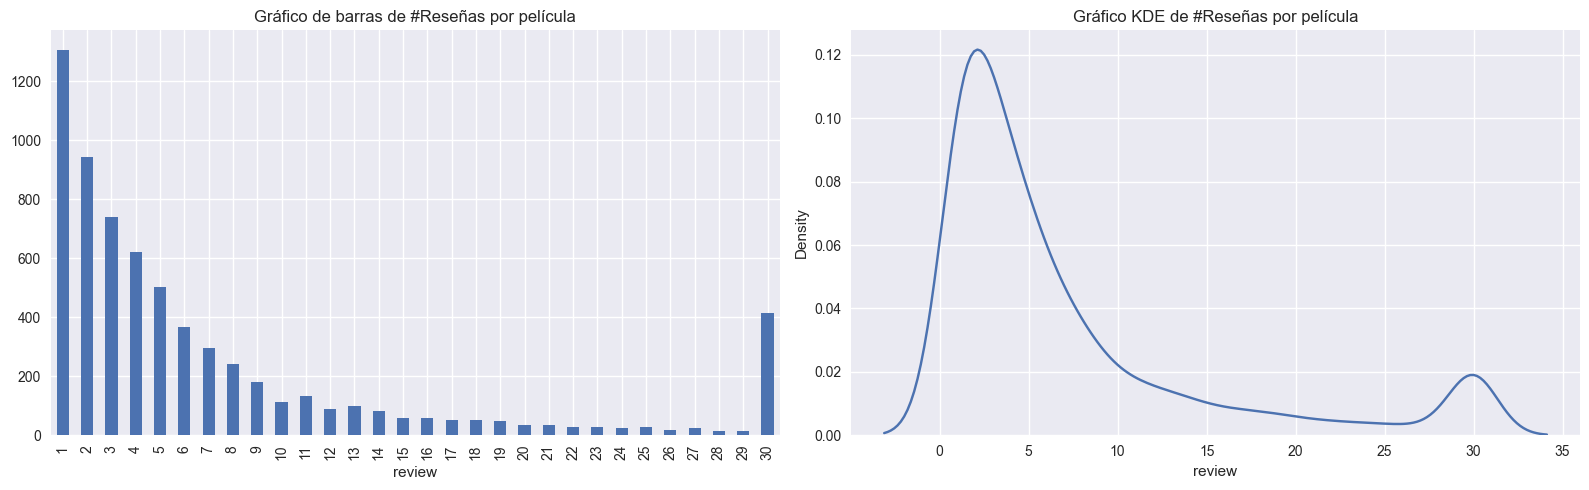

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

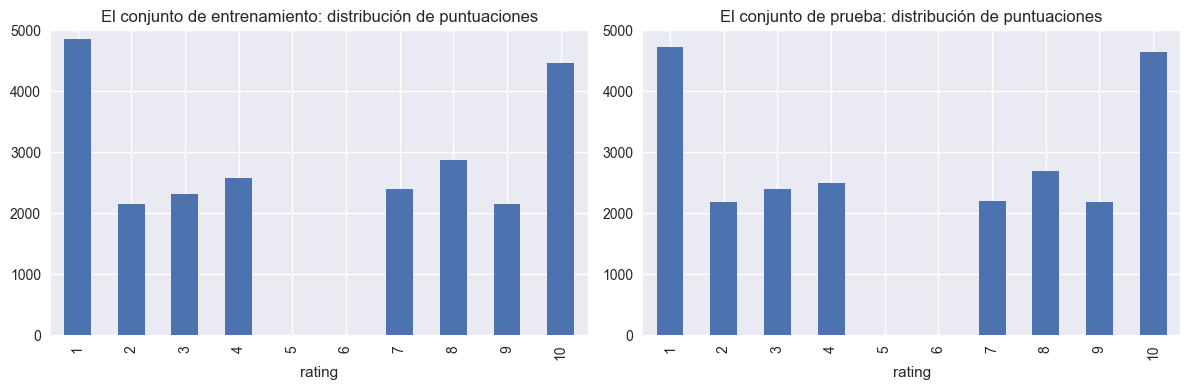

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\Oliver\AppData\Local\Temp\ipykernel_15268\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\Oliver\AppData\Local\Temp\ipykernel_15268\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\Oliver\AppData\Local\Temp\ipykernel_15268\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\Oliver\AppData\Local\Temp\ipykernel_15268\1324160450.py:31: UserWarning: 

Support f

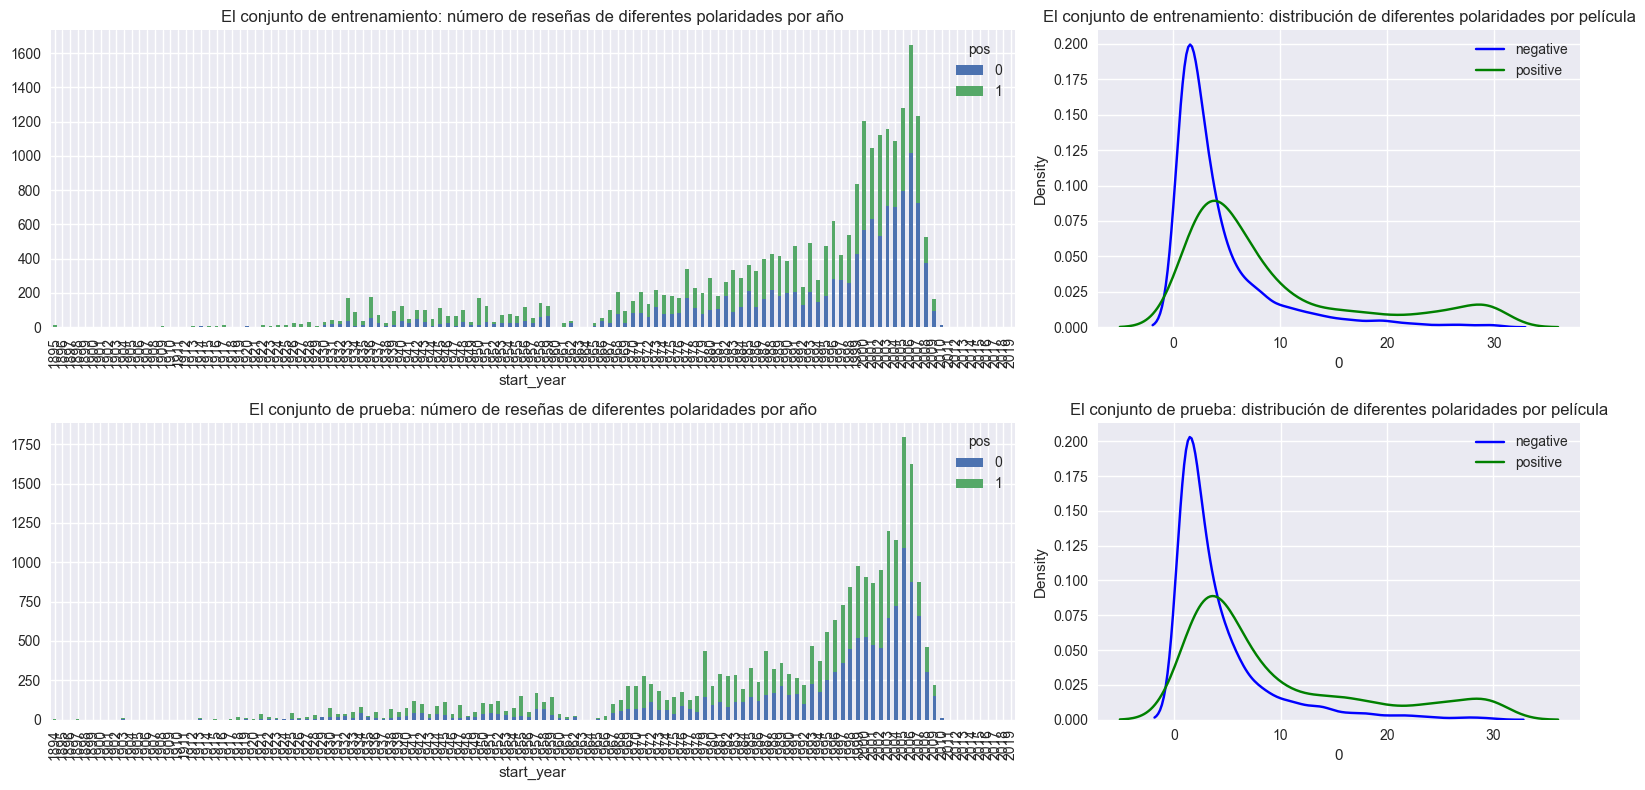

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

La distrubición en general es bastante similar para ambos conjuntos, si todo se hace bien, debería dar muy buenos resultados el modelo entrenado.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [14]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [15]:
import re

def normalize_text_basic(text):
    text = text.lower()
    
    # Eliminar dígitos y signos de puntuación
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Aplicar a la columna review
df_reviews['review_norm'] = df_reviews['review'].astype(str).apply(normalize_text_basic)

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_texts = df_reviews_train['review_norm']
test_texts = df_reviews_test['review_norm']

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
dummy = DummyClassifier(strategy='most_frequent', random_state=123)
dummy.fit(train_texts, train_target)

DummyClassifier(random_state=123, strategy='most_frequent')

           train  test
Exactitud    0.5   0.5
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


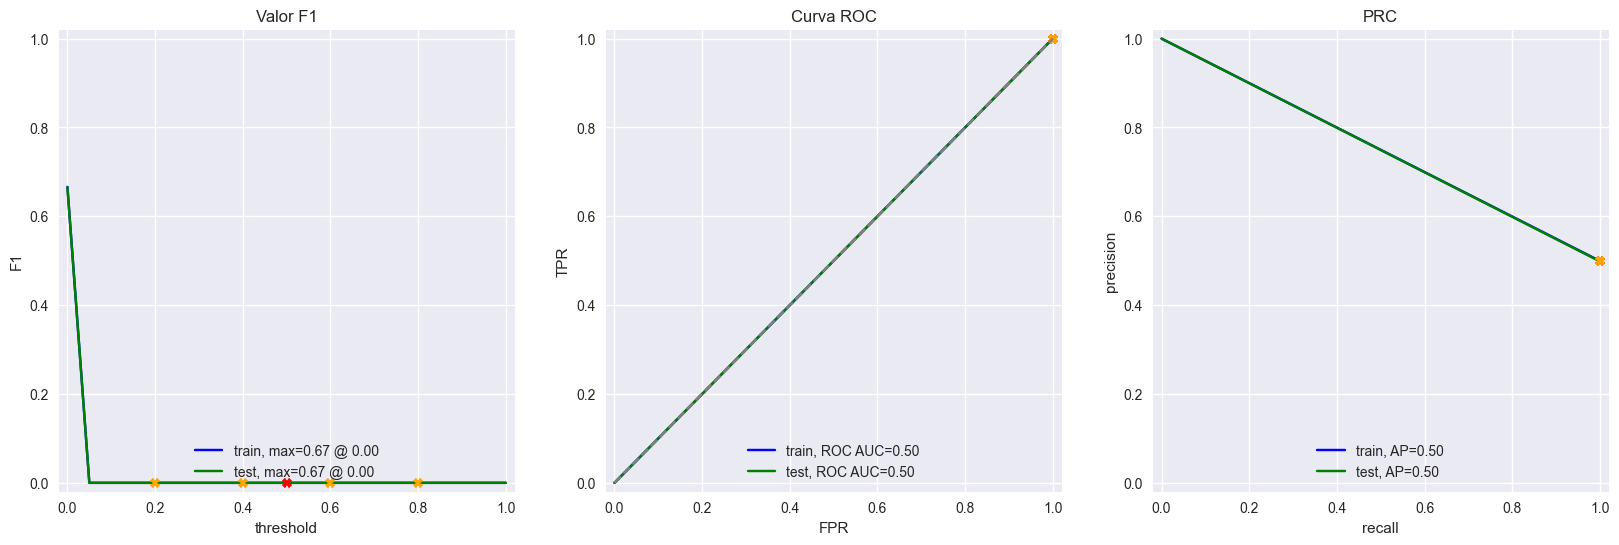

In [19]:
evaluate_model(dummy, train_texts, train_target, test_texts, test_target)

Como es de esperarse, el modelo dummy tiene muy malos resultados, pero es un buen punto de partida para hacer las comparaciones con los modelos que vamos a usar

### Modelo 2 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

Primero vamos a hacer una prueba sin nltk para ver si mejora el modelo con lematización y eliminando stopwords

In [21]:
vectorizer_test = TfidfVectorizer()
train_features_1_test = vectorizer_test.fit_transform(train_texts)
test_features_1_test = vectorizer_test.transform(test_texts)

model_1_test = LogisticRegression(random_state=4321)
model_1_test.fit(train_features_1_test, train_target)

LogisticRegression(random_state=4321)

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


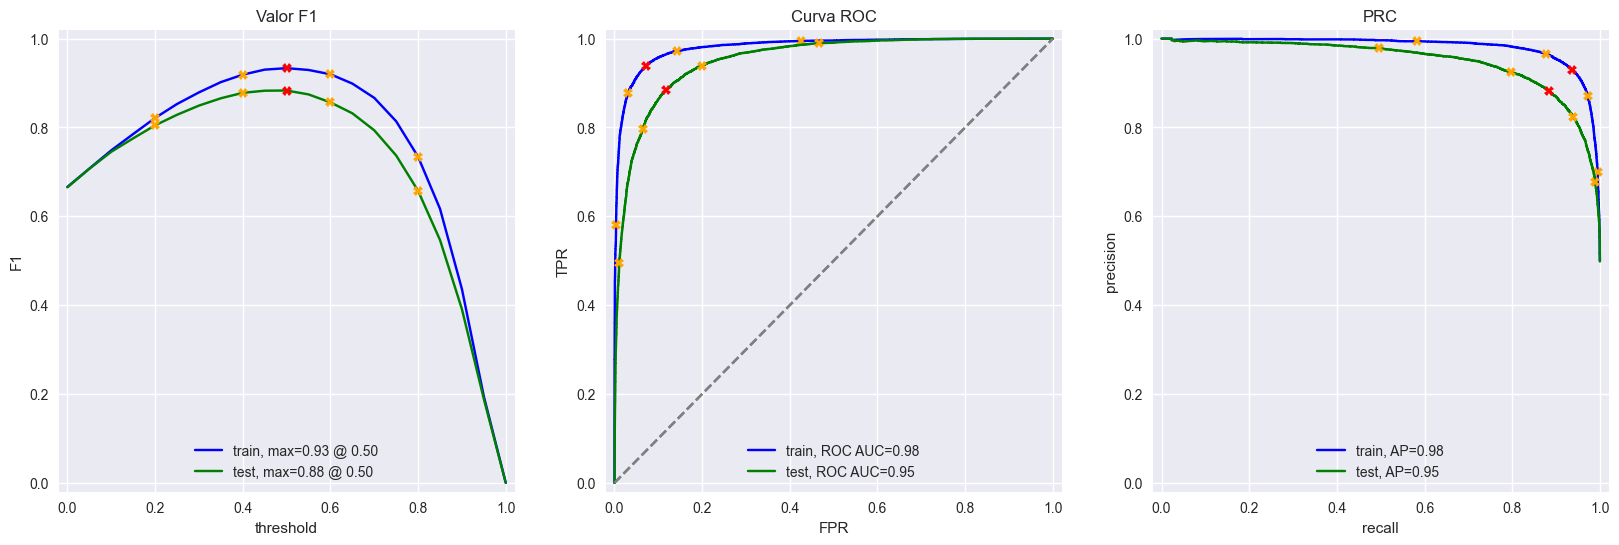

In [22]:
evaluate_model(model_1_test, train_features_1_test, train_target, test_features_1_test, test_target)

Ahora haremos la prueba con lematización y eliminación de stop words, aunque el modelo sin éstas dio muy buenos resultados

In [23]:
##Descargar la primera vez que se ejecute el código
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('wordnet')

In [24]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = []
    for w in tokens:
        if w not in stop_words:
            lemma = lemmatizer.lemmatize(w)
            cleaned_tokens.append(lemma)

    return ' '.join(cleaned_tokens)

train_texts_2 = train_texts.apply(lemmatize)
test_texts_2 = test_texts.apply(lemmatize)

In [25]:
tfidf_vectorizer_2 = TfidfVectorizer()

train_features_2 = tfidf_vectorizer_2.fit_transform(train_texts_2)
test_features_2 = tfidf_vectorizer_2.transform(test_texts_2)

model_2 = LogisticRegression(random_state=4321)
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=4321)

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


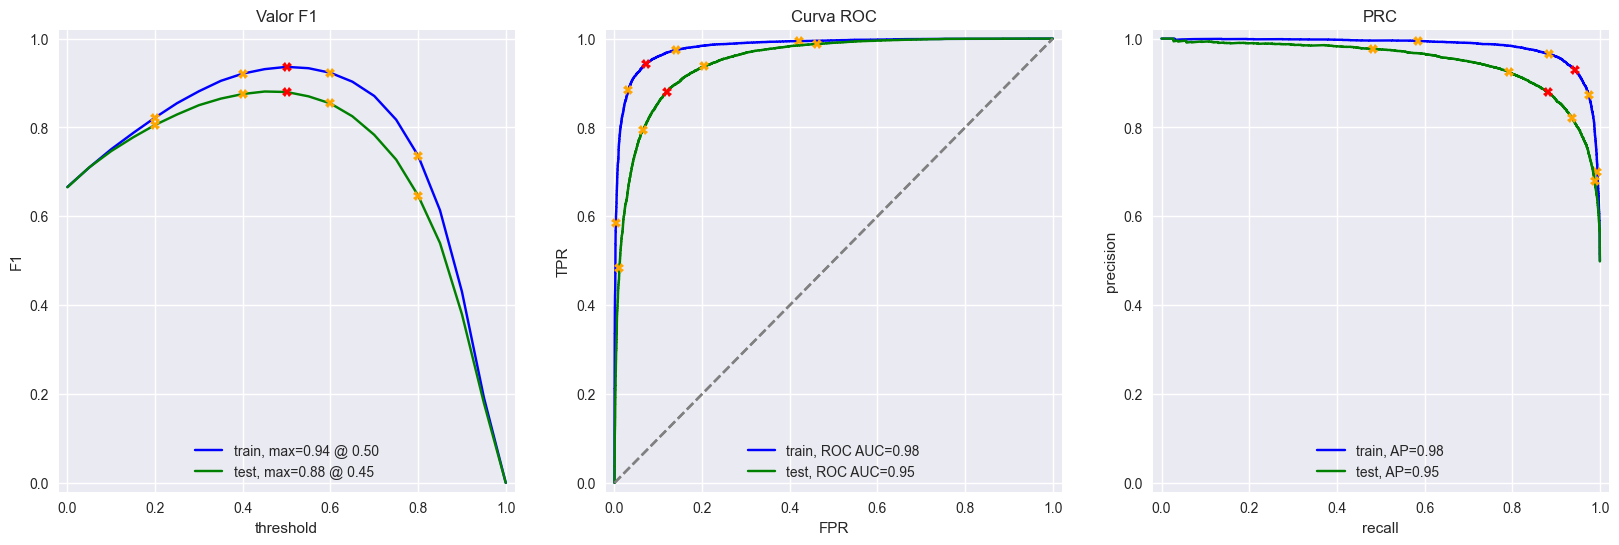

In [26]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

La lematizacion parece no afectar al conjunto de prueba en los resultados de precisión, el modelo es igual de bueno trabajando con textos con una limpieza básica como trabajando con el texto lematizado.

### Modelo 3 - spaCy, TF-IDF y LR

In [27]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
def text_preprocessing_3(texts, n_process=None, batch_size=100):
    if n_process is None:
        n_process = os.cpu_count()
    processed_texts = []

    for doc in nlp.pipe(texts, n_process=n_process, batch_size=batch_size):
        tokens = [token.lemma_ for token in doc]
        processed_texts.append(' '.join(tokens))

    return processed_texts



In [29]:
train_texts_3 = text_preprocessing_3(train_texts)
test_texts_3 = text_preprocessing_3(test_texts)

In [30]:
tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(train_texts_3)
test_features_3 = tfidf_vectorizer_3.transform(test_texts_3)

In [31]:
model_3 = LogisticRegression(random_state=1578)
model_3.fit(train_features_3, train_target)

LogisticRegression(random_state=1578)

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


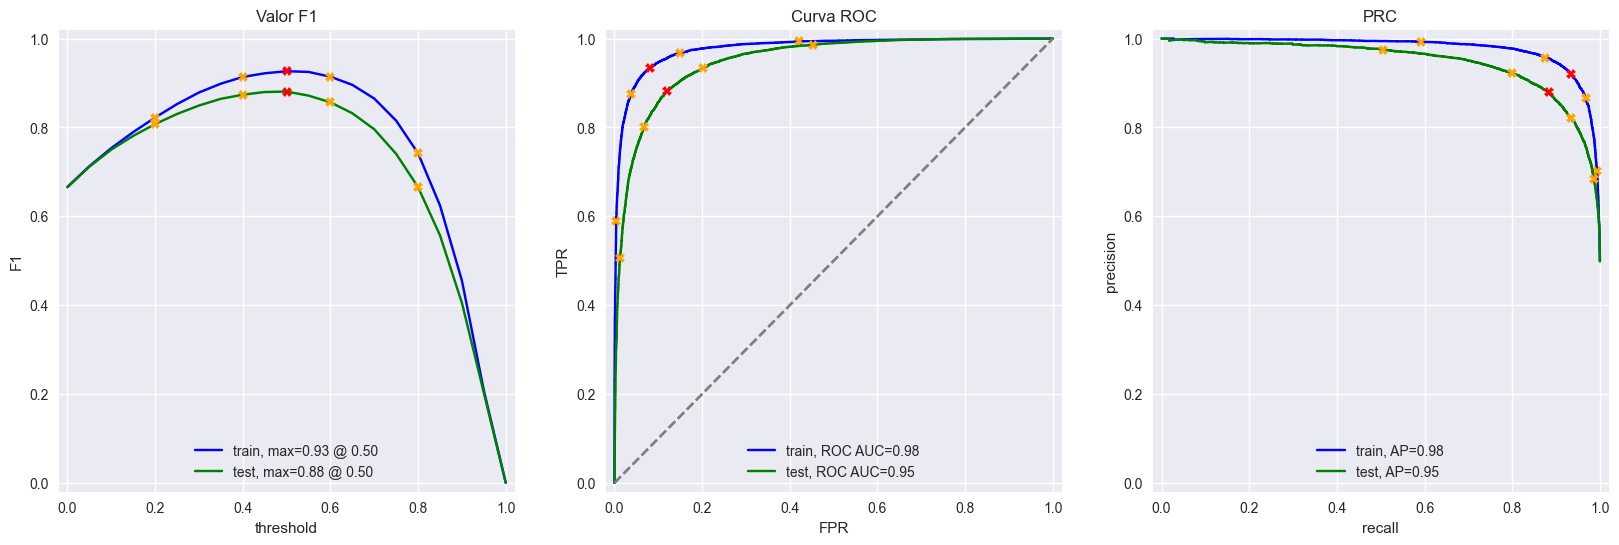

In [32]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [33]:
model_4 = LGBMClassifier(random_state=2025)
model_4.fit(train_features_3, train_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471938
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9457
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(random_state=2025)

           train  test
Exactitud   0.92  0.86
F1          0.92  0.86
APS         0.98  0.93
ROC AUC     0.98  0.94


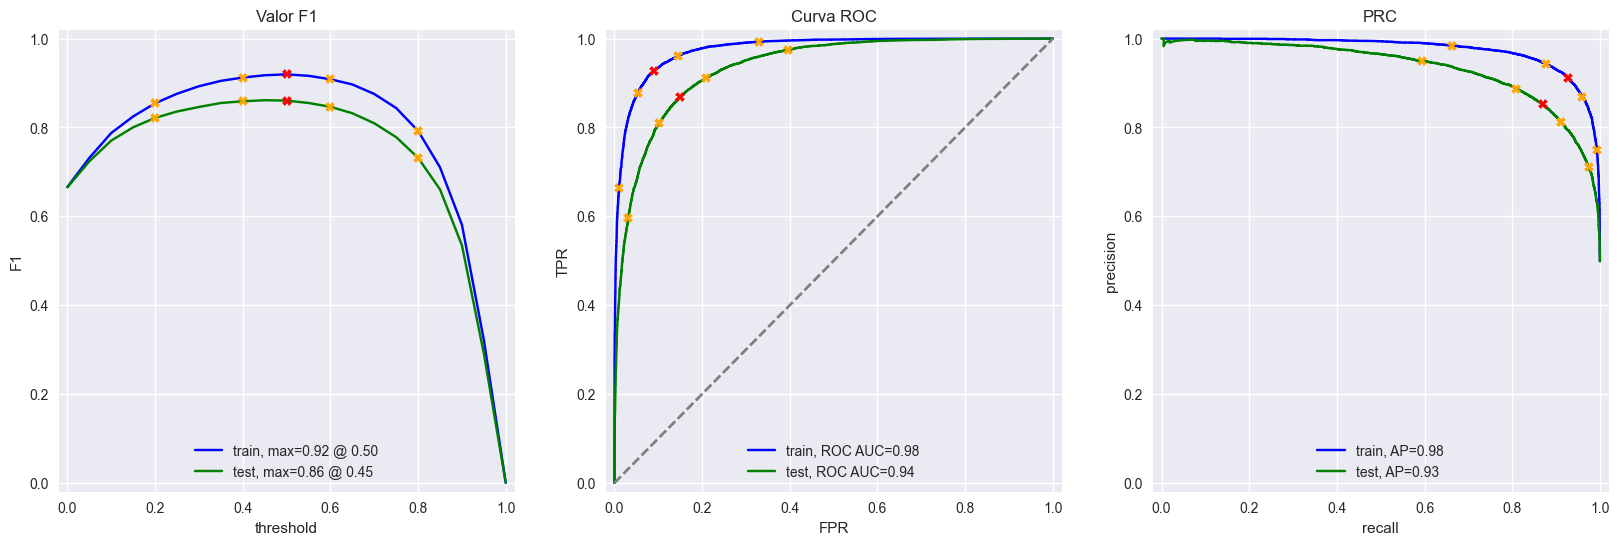

In [34]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

El modelo LGBM también logró el cumplir con el valor F1 requerido, aunque tuvo un desempeño ligeramente menor a su contraparte con Regresión Logística, esto sin ajustar hiperparámetros en ninguno de los dos.

###  Modelo 9 - BERT

In [35]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

c:\Users\Oliver\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
'''
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto para las ID de tokens completadas con sus máscaras de atención
    min_tokenized_text_length = 1e7  # Comience con un valor grande
    max_tokenized_text_length = 0  # Empezar con 0

    # Iterar a través de cada texto en la lista de entrada
    for text in texts:

        ids = tokenizer.encode(text.lower(), add_special_tokens=True)

        ids_len = len(ids)

        if ids_len < min_tokenized_text_length:
            min_tokenized_text_length = ids_len
        elif ids_len > max_tokenized_text_length:
            max_tokenized_text_length = ids_len

        # Truncar los ID de los tokens si superan max_length.  Los modelos BERT tienen un límite
        # en la longitud de la secuencia de entrada.
        ids = ids[:max_length]

        padded = np.array(ids + [0] * (max_length - len(ids)))
        
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

        
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i : batch_size*(i+1)]).to(device)
        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)
'''

"\ndef BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):\n    \n    ids_list = []\n    attention_mask_list = []\n\n    # texto para las ID de tokens completadas con sus máscaras de atención\n    min_tokenized_text_length = 1e7  # Comience con un valor grande\n    max_tokenized_text_length = 0  # Empezar con 0\n\n    # Iterar a través de cada texto en la lista de entrada\n    for text in texts:\n\n        ids = tokenizer.encode(text.lower(), add_special_tokens=True)\n\n        ids_len = len(ids)\n\n        if ids_len < min_tokenized_text_length:\n            min_tokenized_text_length = ids_len\n        elif ids_len > max_tokenized_text_length:\n            max_tokenized_text_length = ids_len\n\n        # Truncar los ID de los tokens si superan max_length.  Los modelos BERT tienen un límite\n        # en la longitud de la secuencia de entrada.\n        ids = ids[:max_length]\n\n        padded = np.array(ids + [0] * (max_length 

In [37]:

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto para las ID de tokens completadas con sus máscaras de atención
    min_tokenized_text_length = 1e7  # Comience con un valor grande
    max_tokenized_text_length = 0  # Empezar con 0

    # Iterar a través de cada texto en la lista de entrada
    for text in texts:

        ids = tokenizer.encode(text.lower(), add_special_tokens=True)

        ids_len = len(ids)

        if ids_len < min_tokenized_text_length:
            min_tokenized_text_length = ids_len
        elif ids_len > max_tokenized_text_length:
            max_tokenized_text_length = ids_len

        # Truncar los ID de los tokens si superan max_length.  Los modelos BERT tienen un límite
        # en la longitud de la secuencia de entrada.
        ids = ids[:max_length]

        padded = np.array(ids + [0] * (max_length - len(ids)))
        
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

        
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_np = np.array(ids_list[batch_size*i:batch_size*(i+1)])
        ids_batch = torch.LongTensor(ids_np).to(device)
        attn_np = np.array(attention_mask_list[batch_size*i : batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attn_np).to(device)
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)


In [38]:
if os.path.exists('features_9.npz'):
    print("Archivo de embeddings ya existe. Cargando desde disco...")
    with np.load('features_9.npz') as data:
        train_features_9 = data['train_features_9']
        test_features_9 = data['test_features_9']
else:
    print("No se encontró archivo de embeddings. Procesando con BERT...")
    train_features_9 = BERT_text_to_embeddings(train_texts, force_device='cuda')
    test_features_9 = BERT_text_to_embeddings(test_texts, force_devide='cuda')
    np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

Archivo de embeddings ya existe. Cargando desde disco...


In [39]:

print(train_texts.shape)
print(train_features_9.shape)
print(train_target.shape)


(23796,)
(23796, 768)
(23796,)


In [40]:
model_9 = LogisticRegression(
    random_state=1234, class_weight='balanced', solver='lbfgs')

model_9.fit(train_features_9, train_target)

c:\Users\Oliver\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=1234)

           train  test
Exactitud   0.87  0.86
F1          0.87  0.86
APS         0.94  0.93
ROC AUC     0.94  0.93


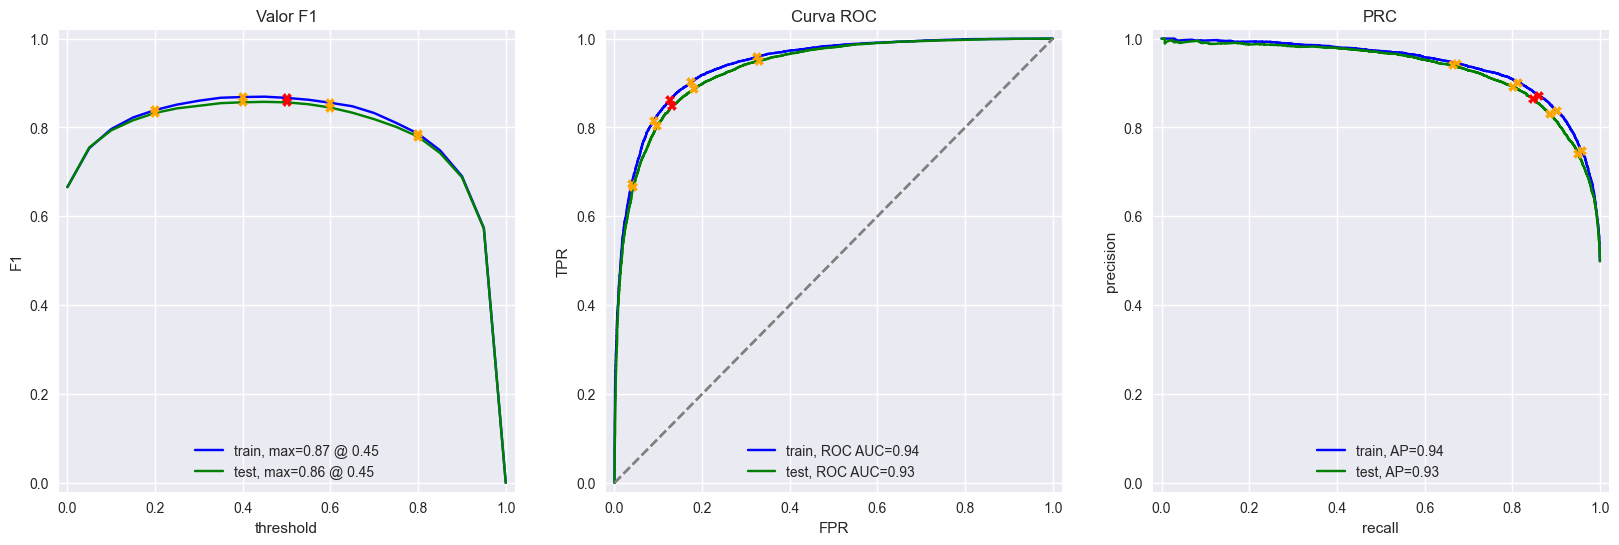

In [41]:
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

Curiosamente, el modelo de Bert es el que peores resultados tuvo con nuestros conjuntos de entrenamiento y prueba, sin contar el modelo dummy por supuesto. Aunque los resultados no fueron considerablemente peores a los del resto de los modelos, la expectativa era que éste tuviera los mejores resultados dada su complejidad y tiempo de ejecución para la tokenización y vectorización.

## Mis reseñas

Ahora que todos los modelos están entrenados y probados con la data original, vamos a ver si puede trabajar con otros textos. El objetivo de esta sección es ver si están bien entrenados y pueden analizar el sentimiento de otras oraciones sugeridas para ver qué tan bien lo manejan.

In [42]:

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])



my_reviews['review_norm'] = my_reviews['review'].astype(str).apply(normalize_text_basic)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 2

In [43]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.32:  i did not simply like it not my kind of movie
0.23:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didnt expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.89:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [44]:
texts = my_reviews['review_norm']

#my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

texts_proc_3 = text_preprocessing_3(texts)
my_reviews_pred_prob = model_3.predict_proba(
    tfidf_vectorizer_3.transform(texts_proc_3))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didnt expect the reboot to be so good writers really cared about the source material
0.69:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


In [45]:
print(texts_proc_3)

['I do not simply like it not my kind of movie', 'well I be bored and feel asleep in the middle of the movie', 'I be really fascinated with the movie', 'even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab', 'I do not expect the reboot to be so good writer really care about the source material', 'the movie have its upside and downside but I feel like overall its a decent flick I could see myself go to see it again', 'what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this', 'launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama']


### Modelo 4

In [46]:
tfidf_vectorizer_4 = tfidf_vectorizer_3
texts_proc_4 = texts_proc_3
#my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

my_reviews_pred_prob = model_4.predict_proba(
    tfidf_vectorizer_4.transform(texts_proc_4))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.45:  i did not simply like it not my kind of movie
0.59:  well i was bored and felt asleep in the middle of the movie
0.64:  i was really fascinated with the movie
0.60:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.50:  i didnt expect the reboot to be so good writers really cared about the source material
0.82:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.30:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

In [47]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.45:  i did not simply like it not my kind of movie
0.02:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.07:  i didnt expect the reboot to be so good writers really cared about the source material
0.99:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

Respecto a la prueba de los modelos en la última sección, estoy satisfecho con los resultados. Producen resultados diferentes, pero en general cumplen con el objetivo de clasificar correctamente si una reseña es positiva o negativa, y qué tan inclinada está hacia cada opción. Bert tiene las probabilidades más extremas, la mayoría de los valores están o muy pegados al 0 o muy pegados al 1, esto puede haber influido a que haya tenido un desempeño ligeramente menor al del resto de los modelos en cuanto a su calificación de F1.

Todos los modelos, con excepción del dummy y de Bert, que se quedó en .86, cumplieron con la métrica f1 de .88, esto se puede deber a que el conjunto de datos era relativamente pequeño, y se necesitaban más datos de entrenamiento para obtener los mejores resultados con este modelo tan complejo, pero de igual forma demostró un buen poder de clasificación para los textos

Este tipo de modelos puede ser increíblemente útil para la predicción de muchos aspectos relacionados al texto, en este caso para saber si una reseña es positiva o negativa, pero puede tener muchas más aplicaciones. Como vimos en este proyecto, diferentes modelos pueden ser mejores en diferentes situaciones, por eso es bueno experimentar con las opciones y decidir cuál es el más conveniente, por ejemplo, para este caso se puede ahorrar mucho recurso computacional al haber visto que Bert no es nuestra mejor alternativa.